# Developing and Analyzing Fairness in Algorithmic Policing

Law enforcement agencies in the United States use predictive policing algorithms to analyze past crime data and identify high-risk areas where officers are directed to patrol during each shift. This project aims to develop a predictive algorithm using a US criminological dataset and to identify and mitigate biases that may disproportionately affect marginalized communities. The focus is on evaluating the model's performance and fairness both before and after implementing bias mitigation techniques. By addressing these biases, the goal is to understand how a more equitable crime prediction model that provides unbiased insights and predictions can be developed, ultimately contributing to fairer decision-making processes in algorithmic policing.

---



### Imports

In [98]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score


random_state = 42

In [99]:
! pip install ucimlrepo

### Data

In [100]:
# Fetch dataset
communities_and_crime = fetch_ucirepo(id=183)

feature_df = communities_and_crime["data"]["features"]
target_df = communities_and_crime["data"]["targets"]

data_df = feature_df.join(target_df)

print(f"Shape of df: {data_df.shape}")

data_df.head()

Shape of df: (1994, 128)


,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03


## Developing the policing algorithm

Let's now put ourselves in the shoes of a data analyst working for the US Criminal Justice Services. We've been asked to develop a predictive algorithm that can determine high crime areas in which a high number of police patrol needs to be deployed.

We will use the Community and Crima data from the UCI repository and apply a standard analytical process to end up with a highly accurate prediction model.

In [101]:
# Inspect the content of communities_and_crime
print(communities_and_crime.metadata)
print(communities_and_crime.variables)

{'uci_id': 183, 'name': 'Communities and Crime', 'repository_url': 'https://archive.ics.uci.edu/dataset/183/communities+and+crime', 'data_url': 'https://archive.ics.uci.edu/static/public/183/data.csv', 'abstract': 'Communities within the United States. The data combines socio-economic data from the 1990 US Census, law enforcement data from the 1990 US LEMAS survey, and crime data from the 1995 FBI UCR.', 'area': 'Social Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 1994, 'num_features': 127, 'feature_types': ['Real'], 'demographics': ['Race', 'Age', 'Income', 'Occupation'], 'target_col': ['ViolentCrimesPerPop'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2002, 'last_updated': 'Mon Mar 04 2024', 'dataset_doi': '10.24432/C53W3X', 'creators': ['Michael Redmond'], 'intro_paper': {'title': 'A data-driven software tool for enabling cooperative information sharing among police departmen

We notice that there are 127 features, including potential targets for our predictive purposes. For our prediction model, we will have to select a subset of features in order to avoid dimensionality to interfere with our model.

Moreover, we notice that there's a high number of missing values in the dataset. This will need to be addressed to ensure our prediction model can be trained without any issues.

In [102]:
data_df.replace("?", pd.NA, inplace=True)

# Get the number of missing values in each column
missing_values = data_df.isna().sum(axis=0)

# Filter columns with missing values
columns_with_missing_values = missing_values[missing_values > 0]

print(columns_with_missing_values)

county                  1174
community               1177
OtherPerCap                1
LemasSwornFT            1675
LemasSwFTPerPop         1675
LemasSwFTFieldOps       1675
LemasSwFTFieldPerPop    1675
LemasTotalReq           1675
LemasTotReqPerPop       1675
PolicReqPerOffic        1675
PolicPerPop             1675
RacialMatchCommPol      1675
PctPolicWhite           1675
PctPolicBlack           1675
PctPolicHisp            1675
PctPolicAsian           1675
PctPolicMinor           1675
OfficAssgnDrugUnits     1675
NumKindsDrugsSeiz       1675
PolicAveOTWorked        1675
PolicCars               1675
PolicOperBudg           1675
LemasPctPolicOnPatr     1675
LemasGangUnitDeploy     1675
PolicBudgPerPop         1675
dtype: int64


Let's remove columns that have a disproportionate amount of missing values from consideration.

In [103]:
# Remove columns with missing values from the DataFrame
df_cleaned = data_df.drop(columns=columns_with_missing_values.index)

# Display the cleaned DataFrame
print(f"Number of columns removed: {len(columns_with_missing_values)}")

missing_values = df_cleaned.isna().sum(axis=0)

print(f"Columns with missing values: {missing_values[missing_values > 0]}")

Number of columns removed: 25
Columns with missing values: Series([], dtype: int64)


Now let's determine the correlation between the features and the target variable __ViolentCrimesPerPop__. Since we have a lot of features, our aim here is to

In [104]:
# Select only numeric columns
numeric_df = df_cleaned.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

temp = correlation_matrix["ViolentCrimesPerPop"].reset_index()

correlation_threshold = 0.50

high_correlation_df = temp[(temp["ViolentCrimesPerPop"] < - correlation_threshold) | (temp["ViolentCrimesPerPop"] > correlation_threshold)]

high_correlation_df

,index,ViolentCrimesPerPop
4,racepctblack,0.631264
5,racePctWhite,-0.684770
17,pctWInvInc,-0.576324
19,pctWPubAsst,0.574665
29,PctPopUnderPov,0.521877
33,PctUnemployed,0.504235
39,MalePctDivorce,0.525407
41,FemalePctDiv,0.556032
42,TotalPctDiv,0.552777
44,PctFam2Par,-0.706667


Now we have a set of features that are highly correlated to our target variable.

We notice that __racepctblack__ and __racePctWhite__ are respectively highly positively correlation and highly negatively correlated with __ViolentCrimesPerPop__.

This is clear indication the race distribution of a particular community is highly correlated with the violent crimes happening in that community.

As a data analyst for US Criminal Justice Services, this might be an indication of biased data - given historical circumstances in which black communities have been marginalised and always been poorer than their white neighbouring communities. A lack of funds and resources might have created an enviroment where crime was the only action that guaranteed survival and potential financial benefit.

Given that our sensitive position, we decide to omit the information related to race as an attempt to ensure that hte algorithm would discriminate on the base of race.

Same thing applies for the __MalePctDivorce__ and __FemalePctDiv__, which might discriminate on the base of gender.

In [105]:
high_correlation_features = high_correlation_df[~high_correlation_df["index"].isin(["racepctblack", "racePctWhite",
                                                                                    "FemalePctDiv", "MalePctDivorce",
                                                                                    "ViolentCrimesPerPop"])]["index"].unique()

print(f"Selected features: {high_correlation_features}")


Selected features: ['pctWInvInc' 'pctWPubAsst' 'PctPopUnderPov' 'PctUnemployed' 'TotalPctDiv'
 'PctFam2Par' 'PctKids2Par' 'PctYoungKids2Par' 'PctTeen2Par' 'PctIlleg'
 'PctPersOwnOccup']


In [106]:
#attributes = [
#    "racepctblack",
#    "pctWInvInc",
#    "pctWPubAsst",
#    "NumUnderPov",
#    "PctPopUnderPov",
#    "PctUnemployed",
#    "MalePctDivorce",
#    "FemalePctDiv",
#    "TotalPctDiv",
#    "PersPerFam",
#    "PctKids2Par",
#    "PctYoungKids2Par",
#    "PctTeen2Par",
#    "PctPersOwnOccup",
#    "HousVacant",
#    "PctHousOwnOcc",
#    "PctVacantBoarded",
#    "NumInShelters",
#    "NumStreet",
#    "ViolentCrimesPerPop"
#]
#
#df = df[attributes]

In [107]:
df_cleaned["ViolentCrimesPerPop"] = df_cleaned["ViolentCrimesPerPop"].astype(float)

# Convert column to float, handle the warning by specifying the DataFrame properly if 'df' is a slice
df_cleaned.loc[:, "ViolentCrimesPerPop"] = df_cleaned["ViolentCrimesPerPop"].astype(float)

# Calculate the 90th percentile
high_crime_threshold = df_cleaned["ViolentCrimesPerPop"].quantile(0.85)

# Use this threshold to determine high crime areas
df_cleaned['HighCrime'] = df_cleaned['ViolentCrimesPerPop'] >= high_crime_threshold

# Display the threshold and the first few entries to check
print("High Crime Threshold:", high_crime_threshold)
df_cleaned[['ViolentCrimesPerPop', 'HighCrime']].head()


High Crime Threshold: 0.48


,ViolentCrimesPerPop,HighCrime
0,0.20,False
1,0.67,True
2,0.43,False
3,0.12,False
4,0.03,False


In [108]:
df_cleaned["HighCrime"].describe()

count      1994
unique        2
top       False
freq       1686
Name: HighCrime, dtype: object

In [109]:
df_cleaned[["racepctblack", "racePctWhite", "racePctAsian", "racePctHisp"]]

,racepctblack,racePctWhite,racePctAsian,racePctHisp
0,0.02,0.90,0.12,0.17
1,0.12,0.74,0.45,0.07
2,0.49,0.56,0.17,0.04
3,1.00,0.08,0.12,0.10
4,0.02,0.95,0.09,0.05
...,...,...,...,...
1989,0.10,0.87,0.12,0.16
1990,0.46,0.28,0.83,0.32
1991,0.25,0.69,0.04,0.25
1992,0.06,0.87,0.22,0.10


In [110]:
df_cleaned["racepctblack"].describe()

count    1994.000000
mean        0.179629
std         0.253442
min         0.000000
25%         0.020000
50%         0.060000
75%         0.230000
max         1.000000
Name: racepctblack, dtype: float64

In [111]:
black_community_threshold = df_cleaned["racepctblack"].quantile(0.85)

print(black_community_threshold)

df_cleaned['isBlack'] = df_cleaned['racepctblack'] > black_community_threshold  # Define black communities

df_cleaned['isBlack'].value_counts()

0.41


isBlack
False    1699
True      295
Name: count, dtype: int64

In [112]:
df = df_cleaned.copy()

### Predictive Model

In [113]:
# Prepare the dataset with the selected features
X = df[high_correlation_features]
y = df['HighCrime']

# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

In [114]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=random_state, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=random_state, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=random_state),
    'Support Vector Classifier': SVC(random_state=random_state),
    'XGBoost': XGBClassifier(random_state=random_state)
}

# Function to perform hyperparameter tuning
def hyperparameter_tuning(model, param_grid):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1')  # Changed scoring from 'accuracy' to 'f1'
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_score_

# Hyperparameter grids
param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5]
    },
    'Support Vector Classifier': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['linear', 'rbf']
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5]
    }
}

# Train and evaluate models
best_models = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    if param_grids[model_name]:
        best_model, best_f1_score = hyperparameter_tuning(model, param_grids[model_name])
        best_models[model_name] = best_model
        print(f"Best {model_name} F1 Score on train set: {best_f1_score}")
    else:
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        f1 = f1_score(y_test, predictions)
        best_models[model_name] = model
        print(f"{model_name} F1 Score: {f1}")

# Select the best model
best_model_name = max(best_models, key=lambda model: f1_score(y_test, best_models[model].predict(X_test)))
best_model = best_models["Logistic Regression"]
best_model_f1 = f1_score(y_test, best_model.predict(X_test))

print(f"Best model: {best_model_name} with F1 Score on test set: {best_model_f1}")

# Calculate F1 Score
f1 = f1_score(y_test, best_model.predict(X_test))
print("F1 Score:", f1)

# Calculate Accuracy
accuracy = accuracy_score(y_test, best_model.predict(X_test))
print("Accuracy:", accuracy)

# Calculate Precision
precision = precision_score(y_test, best_model.predict(X_test))
print("Precision:", precision)

# Calculate Recall
recall = recall_score(y_test, best_model.predict(X_test))
print("Recall:", recall)


Training Logistic Regression...


Best Logistic Regression F1 Score on train set: 0.6145877006175715
Training Random Forest...
Best Random Forest F1 Score on train set: 0.632809778743251
Training Gradient Boosting...
Best Gradient Boosting F1 Score on train set: 0.5967712392198425
Training Support Vector Classifier...
Best Support Vector Classifier F1 Score on train set: 0.597652079323906
Training XGBoost...
Best XGBoost F1 Score on train set: 0.6022100908370123
Best model: Logistic Regression with F1 Score on test set: 0.5583333333333333
F1 Score: 0.5583333333333333
Accuracy: 0.8230383973288815
Precision: 0.42138364779874216
Recall: 0.8271604938271605


In [115]:
# Select the best model
best_model_name = max(best_models, key=lambda model: f1_score(y_test, best_models[model].predict(X_test)))
best_model = best_models[best_model_name]
best_model_f1 = f1_score(y_test, best_model.predict(X_test))

print(f"Best model: {best_model_name} with F1 Score on test set: {best_model_f1}")

Best model: Logistic Regression with F1 Score on test set: 0.5583333333333333


### Error Analysis

              precision    recall  f1-score   support

       False       0.97      0.82      0.89       518
        True       0.42      0.83      0.56        81

    accuracy                           0.82       599
   macro avg       0.69      0.82      0.72       599
weighted avg       0.89      0.82      0.84       599



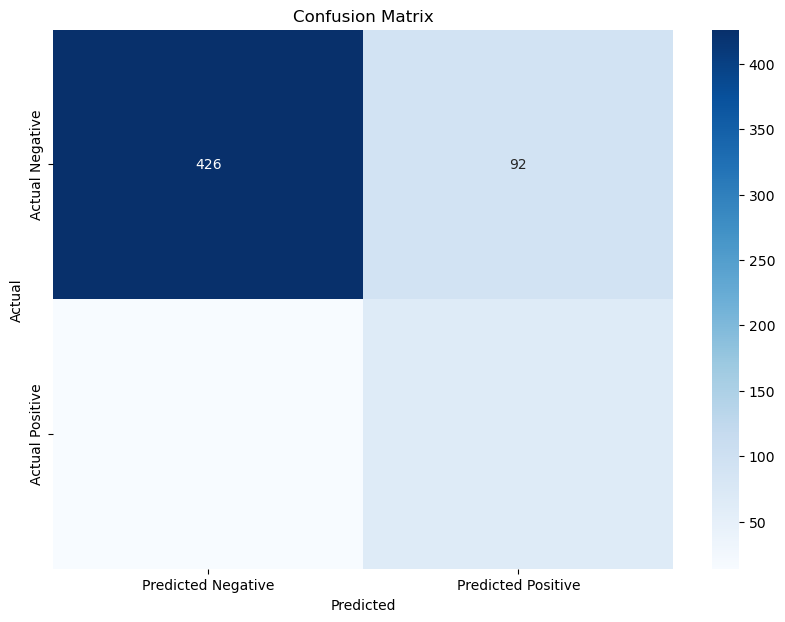

In [116]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on the test set
y_pred = best_model.predict(X_test)

# Get the classification report
print(classification_report(y_test, y_pred))

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_test, y_pred)

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Is the model fair?

Our job as a data analysit working for the US Crimial Justice System has terminated. We have a model with 82% accuracy that can predict areas of high crime given demographic data. The model has an F1 score of 56%, that given our data imbalance we consider to be a good result.

Let's assume this model goes into production and is used to send more patrol cars than usual to predicted high-crime areas. The model is fairly accurate, so we have enough data to justify this.

We now however need to ask ourselves - is this model fair?

In [117]:
# Assuming X_test is your features from the test split and y_test is the actual labels
temp = X_test.copy()

temp['pred'] = best_model.predict(temp)
temp['actual'] = y_test
#X_test['Black'] = X_test['racepctblack'] > 6  # Define black communities

temp[["pred", "actual"]].sort_index()

,pred,actual
2,True,False
15,False,False
23,False,True
29,False,False
30,False,False
...,...,...
1983,True,True
1984,False,False
1986,False,False
1989,False,False


In [118]:
result_df = df[df.index.isin(temp[["pred", "actual"]].sort_index().index)].join(temp[["pred", "actual"]].sort_index())

if sum(result_df["HighCrime"] != result_df["actual"]) != 0:
  print("Mistmatch when joining dataframes!")

print("Result dataframe ready.")

Result dataframe ready.


In [119]:
# Initialize counts
tp_black, tn_black, fp_black, fn_black = 0, 0, 0, 0
tp_non_black, tn_non_black, fp_non_black, fn_non_black = 0, 0, 0, 0

# Calculate counts for black communities
tp_black = ((result_df['pred'] == 1) & (result_df['actual'] == 1) & (result_df['isBlack'])).sum()
tn_black = ((result_df['pred'] == 0) & (result_df['actual'] == 0) & (result_df['isBlack'])).sum()
fp_black = ((result_df['pred'] == 1) & (result_df['actual'] == 0) & (result_df['isBlack'])).sum()
fn_black = ((result_df['pred'] == 0) & (result_df['actual'] == 1) & (result_df['isBlack'])).sum()

# Calculate counts for non-black communities
tp_non_black = ((result_df['pred'] == 1) & (result_df['actual'] == 1) & (~result_df['isBlack'])).sum()
tn_non_black = ((result_df['pred'] == 0) & (result_df['actual'] == 0) & (~result_df['isBlack'])).sum()
fp_non_black = ((result_df['pred'] == 1) & (result_df['actual'] == 0) & (~result_df['isBlack'])).sum()
fn_non_black = ((result_df['pred'] == 0) & (result_df['actual'] == 1) & (~result_df['isBlack'])).sum()

# Calculate total cases for percentage calculations
total_black = tp_black + tn_black + fp_black + fn_black
total_non_black = tp_non_black + tn_non_black + fp_non_black + fn_non_black

# Calculate and print percentages
print(f"Black Communities: TP: {tp_black/total_black:.2%}, TN: {tn_black/total_black:.2%}, FP: {fp_black/total_black:.2%}, FN: {fn_black/total_black:.2%}")
print(f"Non-Black Communities: TP: {tp_non_black/total_non_black:.2%}, TN: {tn_non_black/total_non_black:.2%}, FP: {fp_non_black/total_non_black:.2%}, FN: {fn_non_black/total_non_black:.2%}")


Black Communities: TP: 46.59%, TN: 7.95%, FP: 44.32%, FN: 1.14%
Non-Black Communities: TP: 5.09%, TN: 82.00%, FP: 10.37%, FN: 2.54%


## Fairness through Group Parities

### Statistical & Demographic parity

Statistical/Demographic Parity assesses whether the proportion of positive outcomes (e.g. an area being predicted as high crime) is the same for all groups.

We can see that in the case of our model, Statistical Parity is not satisfied.

In [120]:
print(f"Positive class / black communities: {(tp_black + fp_black)/total_black:.2%}")

print(f"Positive class / non-black communities: {(tp_non_black + fp_non_black)/total_non_black:.2%}")

print(f"Negative class / black communities: {(tn_black + fn_black)/total_black:.2%}")

print(f"Negative class / non-black communities: {(tn_non_black + fn_non_black)/total_non_black:.2%}")

Positive class / black communities: 90.91%
Positive class / non-black communities: 15.46%
Negative class / black communities: 9.09%
Negative class / non-black communities: 84.54%


In [121]:
positive_black = (tp_black + fp_black) / total_black
positive_non_black = (tp_non_black + fp_non_black) / total_non_black
negative_black = (tn_black + fn_black)/total_black
negative_non_black = (tn_non_black + fn_non_black)/total_non_black

print(f"Positive class / black communities: {(tp_black + fp_black)/total_black:.2%}")
print(f"Positive class / non-black communities: {(tp_non_black + fp_non_black)/total_non_black:.2%}")
print(f"Negative class / black communities: {(tn_black + fn_black)/total_black:.2%}")
print(f"Negative class / non-black communities: {(tn_non_black + fn_non_black)/total_non_black:.2%}")
# Calculate disparity ratio for positive class
# Avoid division by zero by adding a small number (epsilon) to the denominator
epsilon = 1e-10
positive_disparity_ratio_statistical = positive_black / (positive_non_black + epsilon)
negative_disparity_ratio_statistical = negative_non_black / (negative_black + epsilon)
print(" ")
print("Statistical Parity - Overall Metrics")
print(f"  Positive Disparity Ratio: {positive_disparity_ratio_statistical:.2}")
print(f"  Negative Disparity Ratio: {negative_disparity_ratio_statistical:.2}")

Positive class / black communities: 90.91%
Positive class / non-black communities: 15.46%
Negative class / black communities: 9.09%
Negative class / non-black communities: 84.54%
 
Statistical Parity - Overall Metrics
  Positive Disparity Ratio: 5.9
  Negative Disparity Ratio: 9.3


### Equality of opportunity

According to conditional procedure accuracy equality (Berk et al., 2018), the members in each group who exhibit the same behavior should be treated equally in equal proportion

In [122]:
print(f"Positive class / black communities: {tp_black/(tp_black + fn_black):.2%}")

print(f"Positive class / non-black communities: {tp_non_black/(tp_non_black + fn_non_black):.2%}")

print(f"Negative class / black communities: {tn_black/(tn_black + fp_black):.2%}")

print(f"Negative class / non-black communities: {tn_non_black/(tn_non_black + fp_non_black):.2%}")

Positive class / black communities: 97.62%
Positive class / non-black communities: 66.67%
Negative class / black communities: 15.22%
Negative class / non-black communities: 88.77%


In [123]:
print(f"Positive class / black communities: {fp_black/(fp_black + tn_black):.2%}")

print(f"Positive class / non-black communities: {fp_non_black/(fp_non_black + tn_non_black):.2%}")

print(f"Negative class / black communities: {fn_black/(fn_black + tp_black):.2%}")

print(f"Negative class / non-black communities: {fn_non_black/(fn_non_black + tp_non_black):.2%}")

Positive class / black communities: 84.78%
Positive class / non-black communities: 11.23%
Negative class / black communities: 2.38%
Negative class / non-black communities: 33.33%


In [124]:
print(f"Positive class / black communities: {tp_black/(tp_black + fn_black):.2%}")
print(f"Positive class / non-black communities: {tp_non_black/(tp_non_black + fn_non_black):.2%}")
print(f"Negative class / black communities: {tn_black/(tn_black + fp_black):.2%}")
print(f"Negative class / non-black communities: {tn_non_black/(tn_non_black + fp_non_black):.2%}")
positive_black = tp_black/(tp_black + fn_black)
positive_non_black = tp_non_black/(tp_non_black + fn_non_black)
negative_black = tn_black/(tn_black + fp_black)
negative_non_black = tn_non_black/(tn_non_black + fp_non_black)

# Calculate disparity ratio for positive class
# Avoid division by zero by adding a small number (epsilon) to the denominator
epsilon = 1e-10
positive_disparity_ratio_opportunity = positive_black / (positive_non_black + epsilon)
negative_disparity_ratio_opportunity = negative_non_black / (negative_black + epsilon)
print(" ")
print("Equality of Opportunity - Overall Metrics")
print(f"  Positive Disparity Ratio: {positive_disparity_ratio_opportunity:.2}")
print(f"  Negative Disparity Ratio: {negative_disparity_ratio_opportunity:.2}")

Positive class / black communities: 97.62%
Positive class / non-black communities: 66.67%
Negative class / black communities: 15.22%
Negative class / non-black communities: 88.77%
 
Equality of Opportunity - Overall Metrics
  Positive Disparity Ratio: 1.5
  Negative Disparity Ratio: 5.8


### Calibration

According to calibration (Berk et al., 2018; Kleinberg et al., 2016), the proportion of correct predictions
should be equal for each class within each group. Thus, the ratio between true positives (TP) and the total
positive predictions (TP + FP) should be the same for both groups. Similarly, the ratio between true
negatives (TN) and total negative predictions (TN + FN) should be equal in the two groups.

In [125]:
print(f"Positive class / black communities: {tp_black/(tp_black + fp_black):.2%}")

print(f"Positive class / non-black communities: {tp_non_black/(tp_non_black + fp_non_black):.2%}")

print(f"Negative class / black communities: {tn_black/(tn_black + fn_black):.2%}")

print(f"Negative class / non-black communities: {tn_non_black/(tn_non_black + fn_non_black):.2%}")

Positive class / black communities: 51.25%
Positive class / non-black communities: 32.91%
Negative class / black communities: 87.50%
Negative class / non-black communities: 96.99%


In [126]:
print(f"Positive class / black communities: {tp_black/(tp_black + fp_black):.2%}")
print(f"Positive class / non-black communities: {tp_non_black/(tp_non_black + fp_non_black):.2%}")
print(f"Negative class / black communities: {tn_black/(tn_black + fn_black):.2%}")
print(f"Negative class / non-black communities: {tn_non_black/(tn_non_black + fn_non_black):.2%}")
positive_black = tp_black/(tp_black + fp_black)
positive_non_black = tp_non_black/(tp_non_black + fp_non_black)
negative_black = tn_black/(tn_black + fn_black)
negative_non_black = tn_non_black/(tn_non_black + fn_non_black)

# Calculate disparity ratio for positive class
# Avoid division by zero by adding a small number (epsilon) to the denominator
epsilon = 1e-10
positive_disparity_ratio_calibration = positive_black / (positive_non_black + epsilon)
negative_disparity_ratio_calibration = negative_non_black / (negative_black + epsilon)
print(" ")
print("Calibration - Overall Metrics")
print(f"  Positive Disparity Ratio: {positive_disparity_ratio_calibration:.2}")
print(f"  Negative Disparity Ratio: {negative_disparity_ratio_calibration:.2}")

Positive class / black communities: 51.25%
Positive class / non-black communities: 32.91%
Negative class / black communities: 87.50%
Negative class / non-black communities: 96.99%
 
Calibration - Overall Metrics
  Positive Disparity Ratio: 1.6
  Negative Disparity Ratio: 1.1


### False rate
The false rate criterion can be considered as the other side of calibration. It measures the proportion of
erroneous predictions for each class relative to the total predictions (Binns, 2020; Chouldechova, 2017;
Barocas and Selbst, 2016). To satisfy this criterion, it is necessary that the ratio between false positives (FP)
and the total amount of positive predictions (TP + FP) be equal in the two groups. The same applies to the
negative class, where the ratio between false negatives (FN) and the total amount of negative predictions
(TN + FN) should be equal within both groups.

In [127]:
print(f"Positive class / black communities: {fp_black/(tp_black + fp_black):.2%}")

print(f"Positive class / non-black communities: {fp_non_black/(tp_non_black + fp_non_black):.2%}")

print(f"Negative class / black communities: {fn_black/(tn_black + fn_black):.2%}")

print(f"Negative class / non-black communities: {fn_non_black/(tn_non_black + fn_non_black):.2%}")

Positive class / black communities: 48.75%
Positive class / non-black communities: 67.09%
Negative class / black communities: 12.50%
Negative class / non-black communities: 3.01%


In [128]:
print(f"Positive class / black communities: {fp_black/(tp_black + fp_black):.2%}")
print(f"Positive class / non-black communities: {fp_non_black/(tp_non_black + fp_non_black):.2%}")
print(f"Negative class / black communities: {fn_black/(tn_black + fn_black):.2%}")
print(f"Negative class / non-black communities: {fn_non_black/(tn_non_black + fn_non_black):.2%}")
positive_black = fp_black/(tp_black + fp_black)
positive_non_black = fp_non_black/(tp_non_black + fp_non_black)
negative_black = fn_black/(tn_black + fn_black)
negative_non_black = fn_non_black/(tn_non_black + fn_non_black)

# Calculate disparity ratio for positive class
# Avoid division by zero by adding a small number (epsilon) to the denominator
epsilon = 1e-10
positive_disparity_ratio_false_rate = positive_black / (positive_non_black + epsilon)
negative_disparity_ratio_false_rate = negative_non_black / (negative_black + epsilon)
print(" ")
print("False Rate - Overall Metrics")
print(f"  Positive Disparity Ratio: {positive_disparity_ratio_false_rate:.2}")
print(f"  Negative Disparity Ratio: {negative_disparity_ratio_false_rate:.2}")

Positive class / black communities: 48.75%
Positive class / non-black communities: 67.09%
Negative class / black communities: 12.50%
Negative class / non-black communities: 3.01%
 
False Rate - Overall Metrics
  Positive Disparity Ratio: 0.73
  Negative Disparity Ratio: 0.24


### Treatment equality

According to treatment equality, the ratio between errors in positive and negative predictions should be
equal across all groups. Thus, in our example, the ratio between individuals erroneously classified as
recidivists (FP) and those erroneously classified as non-recidivists (FN) should be equal for Blues and
Greens. This criterion is aimed at ensuring that no group will be favored by the system’s misclassifications

In [129]:
print(f"Positive class / black communities: {fp_black/fn_black:.2%}")

print(f"Positive class / non-black communities: {fp_non_black/fn_non_black:.2%}")

print(f"Negative class / black communities: {fn_black/fp_black:.2%}")

print(f"Negative class / non-black communities: {fn_non_black/fp_non_black:.2%}")

Positive class / black communities: 3900.00%
Positive class / non-black communities: 407.69%
Negative class / black communities: 2.56%
Negative class / non-black communities: 24.53%


In [130]:
print(f"Positive class / black communities: {fp_black/fn_black:.2%}")
print(f"Positive class / non-black communities: {fp_non_black/fn_non_black:.2%}") 
print(f"Negative class / black communities: {fn_black/fp_black:.2%}")  
print(f"Negative class / non-black communities: {fn_non_black/fp_non_black:.2%}")

positive_black = fp_black/fn_black
positive_non_black = fp_non_black/fn_non_black
negative_black = fn_black/fp_black
negative_non_black = fn_non_black/fp_non_black

# Calculate disparity ratio for positive class
# Avoid division by zero by adding a small number (epsilon) to the denominator
epsilon = 1e-10
positive_disparity_ratio_treatment = positive_black / (positive_non_black + epsilon)
negative_disparity_ratio_treatment = negative_non_black / (negative_black + epsilon)
print(" ")
print("Treatment - Overall Metrics")
print(f"  Positive Disparity Ratio: {positive_disparity_ratio_treatment:.2}")
print(f"  Negative Disparity Ratio: {negative_disparity_ratio_treatment:.2}")

Positive class / black communities: 3900.00%
Positive class / non-black communities: 407.69%
Negative class / black communities: 2.56%
Negative class / non-black communities: 24.53%
 
Treatment - Overall Metrics
  Positive Disparity Ratio: 9.6
  Negative Disparity Ratio: 9.6


# Bias Analysis

### Data bias

The predictive algorithm was trained using the Community and Crime dataset. Bias in the training data can lead to biased predictions - so we need to analyse the dataset and address any potential bias.

Bias on this dataset may arise on historical circumstances that led to Black communities being subject to stricter policing and hence registered more crimes.
Also the socio-economic conditions of Black communities in the US induces a higher crime rate that it would have otherwise.


In [131]:
df[["racepctblack", "ViolentCrimesPerPop"]].corr()

,racepctblack,ViolentCrimesPerPop
racepctblack,1.000000,0.631264
ViolentCrimesPerPop,0.631264,1.000000


In [132]:
df[["racePctWhite", "ViolentCrimesPerPop"]].corr()

,racePctWhite,ViolentCrimesPerPop
racePctWhite,1.00000,-0.68477
ViolentCrimesPerPop,-0.68477,1.00000


There's a high positive correlation between __recepctblack__ and __ViolentCrimesPerPop__. So already in the data we see how it appears that areas for which there is a high percentage of black people the crime rates are higher. 
In a similar manner, we see how instead __recePctWhite__ and __ViolentCrimesPerPop__ are negatively correlated, which indicates that areas with predominantly white demographic shows low levels of crime. 

In [133]:
# Reweighting based on racepctblack
def calculate_weights(df, target_column, sensitive_attribute):
    weights = df.groupby(sensitive_attribute)[target_column].transform('count')
    weights = 1 / weights
    df['weights'] = weights
    return df

df = calculate_weights(df, 'HighCrime', 'racepctblack')

## Developing a fairer policing algorithm

### Functions

In [134]:
def metrics_count(result_df):
   # Initialize counts
  tp_black, tn_black, fp_black, fn_black = 0, 0, 0, 0
  tp_non_black, tn_non_black, fp_non_black, fn_non_black = 0, 0, 0, 0

  # Calculate counts for black communities
  tp_black = ((result_df['pred'] == 1) & (result_df['actual'] == 1) & (result_df['isBlack'])).sum()
  tn_black = ((result_df['pred'] == 0) & (result_df['actual'] == 0) & (result_df['isBlack'])).sum()
  fp_black = ((result_df['pred'] == 1) & (result_df['actual'] == 0) & (result_df['isBlack'])).sum()
  fn_black = ((result_df['pred'] == 0) & (result_df['actual'] == 1) & (result_df['isBlack'])).sum()

  # Calculate counts for non-black communities
  tp_non_black = ((result_df['pred'] == 1) & (result_df['actual'] == 1) & (~result_df['isBlack'])).sum()
  tn_non_black = ((result_df['pred'] == 0) & (result_df['actual'] == 0) & (~result_df['isBlack'])).sum()
  fp_non_black = ((result_df['pred'] == 1) & (result_df['actual'] == 0) & (~result_df['isBlack'])).sum()
  fn_non_black = ((result_df['pred'] == 0) & (result_df['actual'] == 1) & (~result_df['isBlack'])).sum()

  # Calculate total cases for percentage calculations
  total_black = tp_black + tn_black + fp_black + fn_black
  total_non_black = tp_non_black + tn_non_black + fp_non_black + fn_non_black

  # Calculate and print percentages
  print(f"Black Communities: TP: {tp_black/total_black:.2%}, TN: {tn_black/total_black:.2%}, FP: {fp_black/total_black:.2%}, FN: {fn_black/total_black:.2%}")
  print(f"Non-Black Communities: TP: {tp_non_black/total_non_black:.2%}, TN: {tn_non_black/total_non_black:.2%}, FP: {fp_non_black/total_non_black:.2%}, FN: {fn_non_black/total_non_black:.2%}")

  return tp_black, tn_black, fp_black, fn_black, tp_non_black, tn_non_black, fp_non_black, fn_non_black, total_black, total_non_black


def statistical_parity(tp_black, tn_black, fp_black, fn_black, tp_non_black, tn_non_black, fp_non_black, fn_non_black, total_black, total_non_black):
  print(" ")
  print("STATISTICAL PARITY")
  print("-" * 10)

  positive_black = (tp_black + fp_black) / total_black
  positive_non_black = (tp_non_black + fp_non_black) / total_non_black
  negative_black = (tn_black + fn_black)/total_black
  negative_non_black = (tn_non_black + fn_non_black)/total_non_black
  
  print(f"Positive class / black communities: {(tp_black + fp_black)/total_black:.2%}")
  print(f"Positive class / non-black communities: {(tp_non_black + fp_non_black)/total_non_black:.2%}")
  print(f"Negative class / black communities: {(tn_black + fn_black)/total_black:.2%}")
  print(f"Negative class / non-black communities: {(tn_non_black + fn_non_black)/total_non_black:.2%}")

  # Calculate disparity ratio for positive class
  # Avoid division by zero by adding a small number (epsilon) to the denominator
  epsilon = 1e-10
  positive_disparity_ratio_statistical = positive_black / (positive_non_black + epsilon)
  negative_disparity_ratio_statistical = negative_non_black / (negative_black + epsilon)

  print(" ")
  print("Statistical Parity - Overall Metrics")
  print(f"  Positive Disparity Ratio: {positive_disparity_ratio_statistical:.2}")
  print(f"  Negative Disparity Ratio: {negative_disparity_ratio_statistical:.2}")

  return positive_disparity_ratio_statistical, negative_disparity_ratio_statistical

def equality_of_opportunity(tp_black, tn_black, fp_black, fn_black, tp_non_black, tn_non_black, fp_non_black, fn_non_black):
  print(" ")
  print("EQUALITY OF OPPORTUNITY")
  print("-" * 10)

  print(f"Positive class / black communities: {tp_black/(tp_black + fn_black):.2%}")
  print(f"Positive class / non-black communities: {tp_non_black/(tp_non_black + fn_non_black):.2%}")
  print(f"Negative class / black communities: {tn_black/(tn_black + fp_black):.2%}")
  print(f"Negative class / non-black communities: {tn_non_black/(tn_non_black + fp_non_black):.2%}")

  positive_black = tp_black/(tp_black + fn_black)
  positive_non_black = tp_non_black/(tp_non_black + fn_non_black)
  negative_black = tn_black/(tn_black + fp_black)
  negative_non_black = tn_non_black/(tn_non_black + fp_non_black)
  
  # Calculate disparity ratio for positive class
  # Avoid division by zero by adding a small number (epsilon) to the denominator
  epsilon = 1e-10
  positive_disparity_ratio_opportunity = positive_black / (positive_non_black + epsilon)
  negative_disparity_ratio_opportunity = negative_non_black / (negative_black + epsilon)

  print(" ")
  print("Equality of Opportunity - Overall Metrics")
  print(f"  Positive Disparity Ratio: {positive_disparity_ratio_opportunity:.2}")
  print(f"  Negative Disparity Ratio: {negative_disparity_ratio_opportunity:.2}")
  
  return positive_disparity_ratio_opportunity, negative_disparity_ratio_opportunity

def calibration(tp_black, tn_black, fp_black, fn_black, tp_non_black, tn_non_black, fp_non_black, fn_non_black):
  print(" ")
  print("CALIBRATION")
  print("-" * 10)

  print(f"Positive class / black communities: {tp_black/(tp_black + fp_black):.2%}")
  print(f"Positive class / non-black communities: {tp_non_black/(tp_non_black + fp_non_black):.2%}")
  print(f"Negative class / black communities: {tn_black/(tn_black + fn_black):.2%}")
  print(f"Negative class / non-black communities: {tn_non_black/(tn_non_black + fn_non_black):.2%}")

  positive_black = tp_black/(tp_black + fp_black)
  positive_non_black = tp_non_black/(tp_non_black + fp_non_black)
  negative_black = tn_black/(tn_black + fn_black)
  negative_non_black = tn_non_black/(tn_non_black + fn_non_black)
  
  # Calculate disparity ratio for positive class
  # Avoid division by zero by adding a small number (epsilon) to the denominator
  epsilon = 1e-10
  positive_disparity_ratio_calibration = positive_black / (positive_non_black + epsilon)
  negative_disparity_ratio_calibration = negative_non_black / (negative_black + epsilon)

  print(" ")
  print("Calibration - Overall Metrics")
  print(f"  Positive Disparity Ratio: {positive_disparity_ratio_calibration:.2}")
  print(f"  Negative Disparity Ratio: {negative_disparity_ratio_calibration:.2}")
  
  return positive_disparity_ratio_calibration, negative_disparity_ratio_calibration

def false_rate(tp_black, tn_black, fp_black, fn_black, tp_non_black, tn_non_black, fp_non_black, fn_non_black):
  print(" ")
  print("FALSE RATE")
  print("-" * 10)

  print(f"Positive class / black communities: {fp_black/(tp_black + fp_black):.2%}")
  print(f"Positive class / non-black communities: {fp_non_black/(tp_non_black + fp_non_black):.2%}")
  print(f"Negative class / black communities: {fn_black/(tn_black + fn_black):.2%}")
  print(f"Negative class / non-black communities: {fn_non_black/(tn_non_black + fn_non_black):.2%}")

  positive_black = fp_black/(tp_black + fp_black)
  positive_non_black = fp_non_black/(tp_non_black + fp_non_black)
  negative_black = fn_black/(tn_black + fn_black)
  negative_non_black = fn_non_black/(tn_non_black + fn_non_black)
  
  # Calculate disparity ratio for positive class
  # Avoid division by zero by adding a small number (epsilon) to the denominator
  epsilon = 1e-10
  positive_disparity_ratio_false_rate = positive_black / (positive_non_black + epsilon)
  negative_disparity_ratio_false_rate = negative_non_black / (negative_black + epsilon)

  print(" ")
  print("False Rate - Overall Metrics")
  print(f"  Positive Disparity Ratio: {positive_disparity_ratio_false_rate:.2}")
  print(f"  Negative Disparity Ratio: {negative_disparity_ratio_false_rate:.2}")
  
  return positive_disparity_ratio_false_rate, negative_disparity_ratio_false_rate

def treatment_equality(tp_black, tn_black, fp_black, fn_black, tp_non_black, tn_non_black, fp_non_black, fn_non_black):
  print(" ")
  print("TREATMENT")
  print("-" * 10) 

  print(f"Positive class / black communities: {fp_black/fn_black:.2%}")
  print(f"Positive class / non-black communities: {fp_non_black/fn_non_black:.2%}") 
  print(f"Negative class / black communities: {fn_black/fp_black:.2%}")  
  print(f"Negative class / non-black communities: {fn_non_black/fp_non_black:.2%}")
  
  positive_black = fp_black/fn_black
  positive_non_black = fp_non_black/fn_non_black
  negative_black = fn_black/fp_black
  negative_non_black = fn_non_black/fp_non_black
  
  # Calculate disparity ratio for positive class
  # Avoid division by zero by adding a small number (epsilon) to the denominator
  epsilon = 1e-10
  positive_disparity_ratio_treatment = positive_black / (positive_non_black + epsilon)
  negative_disparity_ratio_treatment = negative_non_black / (negative_black + epsilon)

  print(" ")
  print("Treatment - Overall Metrics")
  print(f"  Positive Disparity Ratio: {positive_disparity_ratio_treatment:.2}")
  print(f"  Negative Disparity Ratio: {negative_disparity_ratio_treatment:.2}")
  
  return positive_disparity_ratio_treatment, negative_disparity_ratio_treatment


def fairness_metrics(model, x_test, df, custom_loss=False, adversarial=False):
    print("FAIRNESS METRICS")
    print("")

    if adversarial:
        # Convert the TensorFlow tensor to a NumPy array
        X_test_np = X_test.numpy()

        # Convert the NumPy array to a Pandas DataFrame
        # Assuming you know the column names, which you can obtain from the original DataFrame before tensor conversion
        column_names = df[high_correlation_features].columns
        X_test_df = pd.DataFrame(X_test_np, columns=column_names)

        # Now you can use the copy() method
        temp = X_test_df.copy()
        print(temp.head())
    else:
      # Assuming X_test is your features from the test split and y_test is the actual labels
      temp = x_test.copy()

    if custom_loss or adversarial:
      temp['pred'] = model.predict(temp) > 0.50
    else:
      temp['pred'] = model.predict(temp)
    temp['actual'] = y_test
    #X_test['Black'] = X_test['racepctblack'] > 6  # Define black communities

    result_df = df[df.index.isin(temp[["pred", "actual"]].sort_index().index)].join(temp[["pred", "actual"]].sort_index())

    if sum(result_df["HighCrime"] != result_df["actual"]) != 0:
      print("Mistmatch when joining dataframes!")
    
    print("Result dataframe ready.")

    tp_black, tn_black, fp_black, fn_black, tp_non_black, tn_non_black, fp_non_black, fn_non_black, total_black, total_non_black = metrics_count(result_df)
    
    positive_disparity_ratio_statistical, negative_disparity_ratio_statistical = statistical_parity(tp_black, tn_black, fp_black, fn_black, tp_non_black, tn_non_black, fp_non_black, fn_non_black, total_black, total_non_black)
    positive_disparity_ratio_opportunity, negative_disparity_ratio_opportunity = equality_of_opportunity(tp_black, tn_black, fp_black, fn_black, tp_non_black, tn_non_black, fp_non_black, fn_non_black)
    positive_disparity_ratio_calibration, negative_disparity_ratio_calibration = calibration(tp_black, tn_black, fp_black, fn_black, tp_non_black, tn_non_black, fp_non_black, fn_non_black)
    positive_disparity_ratio_false_rate, negative_disparity_ratio_false_rate = false_rate(tp_black, tn_black, fp_black, fn_black, tp_non_black, tn_non_black, fp_non_black, fn_non_black)
    positive_disparity_ratio_treatment, negative_disparity_ratio_treatment = treatment_equality(tp_black, tn_black, fp_black, fn_black, tp_non_black, tn_non_black, fp_non_black, fn_non_black)

    return positive_disparity_ratio_statistical, negative_disparity_ratio_statistical, positive_disparity_ratio_opportunity, negative_disparity_ratio_opportunity, positive_disparity_ratio_calibration, negative_disparity_ratio_calibration, positive_disparity_ratio_false_rate, negative_disparity_ratio_false_rate, positive_disparity_ratio_treatment, negative_disparity_ratio_treatment

### Reweighting

In [135]:
# Prepare the dataset with the selected features
X = df[high_correlation_features]
y = df['HighCrime']

# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X, y, df['weights'], test_size=0.3, random_state=42)

In [136]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=random_state, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=random_state, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=random_state),
    'Support Vector Classifier': SVC(random_state=random_state),
    'XGBoost': XGBClassifier(random_state=random_state)
}

# Function to perform hyperparameter tuning
def hyperparameter_tuning(model, param_grid):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1')  # Changed scoring from 'accuracy' to 'f1'
    grid_search.fit(X_train, y_train, sample_weight=weights_train)
    return grid_search.best_estimator_, grid_search.best_score_

# Hyperparameter grids
param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5]
    },
    'Support Vector Classifier': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['linear', 'rbf']
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5]
    }
}

# Train and evaluate models
best_models_reweighting = {}
for model_name_reweighting, model_reweighting in models.items():
    print(f"Training {model_name_reweighting}...")
    if param_grids[model_name_reweighting]:
        best_model_reweighting, best_f1_score_reweighting = hyperparameter_tuning(model_reweighting, param_grids[model_name_reweighting])
        best_models_reweighting[model_name_reweighting] = best_model_reweighting
        print(f"Best {model_name_reweighting} F1 Score on train set: {best_f1_score_reweighting}")
    else:
        model_reweighting.fit(X_train, y_train, sample_weight=weights_train)
        predictions = model_reweighting.predict(X_test)
        f1 = f1_score(y_test, predictions)
        best_models_reweighting[model_name_reweighting] = model_reweighting
        print(f"{model_name_reweighting} F1 Score: {f1}")

# Select the best model
best_model_name_reweighting = max(best_models_reweighting, key=lambda model_reweighting: f1_score(y_test, best_models_reweighting[model_reweighting].predict(X_test)))
best_model_reweighting = best_models_reweighting["Logistic Regression"]
best_model_f1_reweighting = f1_score(y_test, best_model_reweighting.predict(X_test))

print(f"Best model: {best_model_name_reweighting} with F1 Score on test set: {best_model_f1_reweighting}")

# Calculate F1 Score
f1 = f1_score(y_test, best_model_reweighting.predict(X_test))
print("F1 Score:", f1)

# Calculate Accuracy
accuracy = accuracy_score(y_test, best_model_reweighting.predict(X_test))
print("Accuracy:", accuracy)

# Calculate Precision
precision = precision_score(y_test, best_model_reweighting.predict(X_test))
print("Precision:", precision)

# Calculate Recall
recall = recall_score(y_test, best_model_reweighting.predict(X_test))
print("Recall:", recall)


Training Logistic Regression...
Best Logistic Regression F1 Score on train set: 0.5493003106059968
Training Random Forest...


Best Random Forest F1 Score on train set: 0.6193260106749003
Training Gradient Boosting...
Best Gradient Boosting F1 Score on train set: 0.5904366685945633
Training Support Vector Classifier...
Best Support Vector Classifier F1 Score on train set: 0.5721644333409039
Training XGBoost...
Best XGBoost F1 Score on train set: 0.581877846839087
Best model: Random Forest with F1 Score on test set: 0.4808362369337979
F1 Score: 0.4808362369337979
Accuracy: 0.7512520868113522
Precision: 0.33495145631067963
Recall: 0.8518518518518519


              precision    recall  f1-score   support

       False       0.97      0.74      0.84       518
        True       0.33      0.85      0.48        81

    accuracy                           0.75       599
   macro avg       0.65      0.79      0.66       599
weighted avg       0.88      0.75      0.79       599



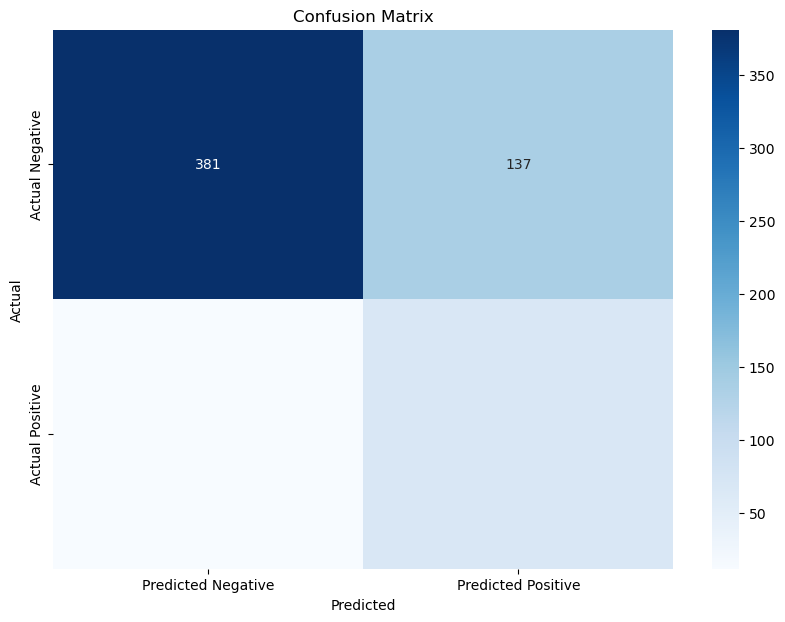

In [137]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on the test set
y_pred = best_model_reweighting.predict(X_test)

# Get the classification report
print(classification_report(y_test, y_pred))

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_test, y_pred)

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [138]:
print("Bias Mitigation Method: Reweighting")
print("")
fairness_metrics(best_model_reweighting, X_test, df)
print("")

Bias Mitigation Method: Reweighting

FAIRNESS METRICS

Result dataframe ready.
Black Communities: TP: 46.59%, TN: 5.68%, FP: 46.59%, FN: 1.14%
Non-Black Communities: TP: 5.48%, TN: 73.58%, FP: 18.79%, FN: 2.15%
 
STATISTICAL PARITY
----------
Positive class / black communities: 93.18%
Positive class / non-black communities: 24.27%
Negative class / black communities: 6.82%
Negative class / non-black communities: 75.73%
 
Statistical Parity - Overall Metrics
  Positive Disparity Ratio: 3.8
  Negative Disparity Ratio: 1.1e+01
 
EQUALITY OF OPPORTUNITY
----------
Positive class / black communities: 97.62%
Positive class / non-black communities: 71.79%
Negative class / black communities: 10.87%
Negative class / non-black communities: 79.66%
 
Equality of Opportunity - Overall Metrics
  Positive Disparity Ratio: 1.4
  Negative Disparity Ratio: 7.3
 
CALIBRATION
----------
Positive class / black communities: 50.00%
Positive class / non-black communities: 22.58%
Negative class / black communit

### Custom Loss Function

In [139]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(
    42
)

# Prepare the dataset with the selected features
X = df[high_correlation_features]
y = df['HighCrime']

# Split the data into training and test sets
X_train, X_test, y_train, y_test, weights_train, weights_test, isBlack_train, isBlack_test = train_test_split(
    X, y, df['weights'], df['isBlack'].astype(int), test_size=0.3, random_state=42)

# Model architecture
input_features = Input(shape=(X_train.shape[1],))
output = Dense(1, activation='sigmoid')(input_features)
model_custom_loss = Model(inputs=input_features, outputs=output)

# Custom loss function with bias penalty
def biased_loss(y_true, y_pred, sensitive):
    standard_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    bias_penalty = tf.reduce_mean(tf.abs(y_pred - tf.cast(sensitive, tf.float32)))  # Simple absolute difference penalty
    return standard_loss + 0.1 * bias_penalty  # Adjust penalty weight as necessary

# Wrap custom loss function to include sensitive attribute
def custom_loss(sensitive):
    def loss(y_true, y_pred):
        return biased_loss(y_true, y_pred, sensitive)
    return loss

# Compile model with custom loss
model_custom_loss.compile(optimizer=Adam(learning_rate=0.001), loss=custom_loss(isBlack_train))

# Train model
model_custom_loss.fit(X_train, y_train, batch_size=64, epochs=10, sample_weight=weights_train)

# Evaluate model
model_custom_loss.evaluate(X_test, y_test)

# Get predictions
y_pred = (model_custom_loss.predict(X_test) > 0.5).astype(int)

# Calculate F1 Score
f1 = f1_score(y_test, y_pred)

# Calculate F1 Score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate Precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Calculate Recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 0.0381
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 0.0371
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 0.0363
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 0.0357
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 0.0352
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 0.0348
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 0.0345
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 0.0342
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 0.0339
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 0.0337
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step - loss: 0.5477
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
F1 Score: 0.13043478260869565
Accuracy: 0.8664440734557596
Precision: 0.5454545454545454
Recall: 0.07407407407407407


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


              precision    recall  f1-score   support

       False       0.87      0.99      0.93       518
        True       0.55      0.07      0.13        81

    accuracy                           0.87       599
   macro avg       0.71      0.53      0.53       599
weighted avg       0.83      0.87      0.82       599



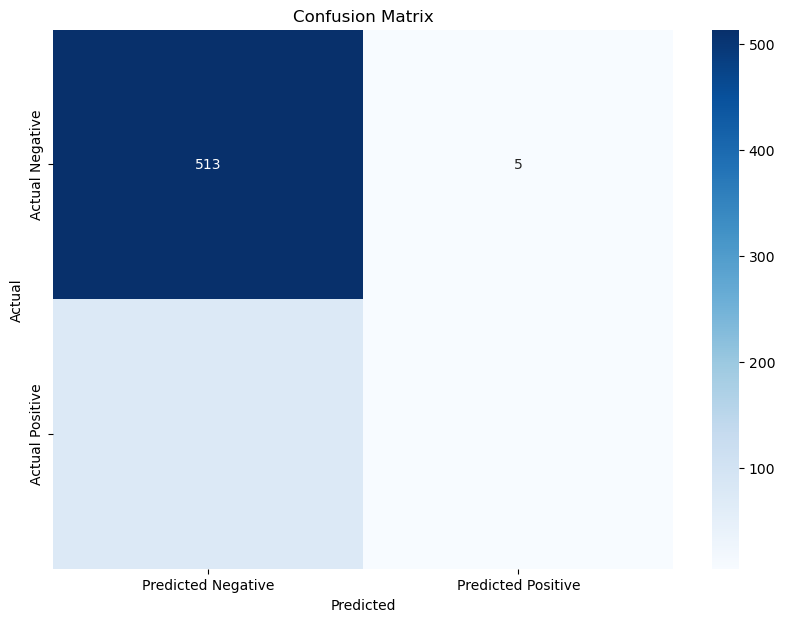

In [140]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on the test set
y_pred = model_custom_loss.predict(X_test) > 0.5
# Get the classification report
print(classification_report(y_test, y_pred))

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_test, y_pred)

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [141]:
print("Bias Mitigation Method: Reweighting")
print("")
fairness_metrics(model_custom_loss, X_test, df, custom_loss=True)
print("")

Bias Mitigation Method: Reweighting

FAIRNESS METRICS

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
Result dataframe ready.
Black Communities: TP: 3.41%, TN: 52.27%, FP: 0.00%, FN: 44.32%
Non-Black Communities: TP: 0.59%, TN: 91.39%, FP: 0.98%, FN: 7.05%
 
STATISTICAL PARITY
----------
Positive class / black communities: 3.41%
Positive class / non-black communities: 1.57%
Negative class / black communities: 96.59%
Negative class / non-black communities: 98.43%
 
Statistical Parity - Overall Metrics
  Positive Disparity Ratio: 2.2
  Negative Disparity Ratio: 1.0
 
EQUALITY OF OPPORTUNITY
----------
Positive class / black communities: 7.14%
Positive class / non-black communities: 7.69%
Negative class / black communities: 100.00%
Negative class / non-black communities: 98.94%
 
Equality of Opportunity - Overall Metrics
  Positive Disparity Ratio: 0.93
  Negative Disparity Ratio: 0.99
 
CALIBRATION
----------
Positive class / black communities: 100.00%
Positive class / non-black communities: 3

/var/folders/dn/_xfnym210t70p3705v9krtf00000gn/T/ipykernel_32782/2986652886.py:148: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"Negative class / black communities: {fn_black/fp_black:.2%}")
/var/folders/dn/_xfnym210t70p3705v9krtf00000gn/T/ipykernel_32782/2986652886.py:153: RuntimeWarning: divide by zero encountered in scalar divide
  negative_black = fn_black/fp_black


### Adversarial Debiasing

In [142]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)

# Prepare the dataset with the selected features
X = df[high_correlation_features]
y = df['HighCrime']
sensitive_attr = df['isBlack'].astype(int)  # Assuming 'isBlack' indicates the sensitive attribute

# Split the data into training and test sets
X_train, X_test, y_train, y_test, sensitive_attr_train, sensitive_attr_test = train_test_split(
    X, y, sensitive_attr, test_size=0.3, random_state=42)

# Convert DataFrame to TensorFlow tensor
X_train, X_test = tf.convert_to_tensor(X_train, dtype=tf.float32), tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train, y_test = tf.convert_to_tensor(y_train, dtype=tf.float32), tf.convert_to_tensor(y_test, dtype=tf.float32)
sensitive_attr_train, sensitive_attr_test = tf.convert_to_tensor(sensitive_attr_train, dtype=tf.float32), tf.convert_to_tensor(sensitive_attr_test, dtype=tf.float32)

# Model architecture for the main model
input_features = Input(shape=(X_train.shape[1],))
main_model_layer = Dense(10, activation='relu')(input_features)
main_model_output = Dense(1, activation='sigmoid', name='main_output')(main_model_layer)
model = Model(inputs=input_features, outputs=main_model_output)

# Adversary model architecture
adversary_input = main_model_output
adversary_layer = Dense(10, activation='relu')(adversary_input)
adversary_output = Dense(1, activation='sigmoid', name='adversary_output')(adversary_layer)
adversary_model = Model(inputs=input_features, outputs=adversary_output)

# Optimizers
model_optimizer = Adam(learning_rate=0.001)
adversary_optimizer = Adam(learning_rate=0.001)

# Compile models
model.compile(optimizer=model_optimizer, loss='binary_crossentropy')
adversary_model.compile(optimizer=adversary_optimizer, loss='binary_crossentropy')

# Custom training loop
batch_size = 32
num_steps = 50  # number of steps to train

for step in range(num_steps):
    # Sample a batch of data
    indices = np.random.randint(0, len(X_train), size=batch_size)
    batch_features = tf.gather(X_train, indices)
    batch_labels = tf.expand_dims(tf.gather(y_train, indices), axis=-1)  # Expand dimensions
    batch_sensitive = tf.expand_dims(tf.gather(sensitive_attr_train, indices), axis=-1)  # Expand dimensions

    # Train the main model
    with tf.GradientTape() as tape:
        predictions = model(batch_features, training=True)
        loss = tf.keras.losses.binary_crossentropy(batch_labels, predictions)
    grads = tape.gradient(loss, model.trainable_weights)
    model_optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # Train the adversary
    with tf.GradientTape() as tape:
        sensitive_predictions = adversary_model(batch_features, training=True)
        loss = tf.keras.losses.binary_crossentropy(batch_sensitive, sensitive_predictions)
    grads = tape.gradient(loss, adversary_model.trainable_weights)
    adversary_optimizer.apply_gradients(zip(grads, adversary_model.trainable_weights))

    # Optionally update the main model to deceive the adversary
    with tf.GradientTape() as tape:
        predictions = model(batch_features, training=True)
        sensitive_predictions = adversary_model(batch_features, training=True)
        loss = tf.keras.losses.binary_crossentropy(batch_labels, predictions) - \
               tf.keras.losses.binary_crossentropy(batch_sensitive, sensitive_predictions)
    grads = tape.gradient(loss, model.trainable_weights)
    model_optimizer.apply_gradients(zip(grads, model.trainable_weights))

    if step % 10 == 0:
        print(f"Step {step}, Loss: {loss.numpy()}")

# Evaluate model
evaluation = model.evaluate(X_test, y_test)
print(f"Evaluation results - Loss: {evaluation}")

# Optionally, calculate additional metrics such as accuracy or AUC
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
accuracy = accuracy_score(y_test.numpy().astype(int), y_pred)
auc_score = roc_auc_score(y_test.numpy(), y_pred)
print(f"Accuracy: {accuracy}, AUC: {auc_score}")
# Calculate F1 Score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Calculate F1 Score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate Precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Calculate Recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)


Step 0, Loss: [-0.06288773  0.00489104  0.02668554 -0.16672695 -0.08091509 -0.06809455
  0.17154354  0.01228487 -0.05877298 -0.07166582 -0.11141205  0.04146856
 -0.06964731 -0.17157644 -0.0750432  -0.06328207 -0.11935294  0.06350309
  0.04529285 -0.04917759 -0.07541037  0.04790789 -0.14224786 -0.09238851
 -0.06445819  0.0561412  -0.0638364  -0.04399616 -0.00206584  0.02028805
 -0.06586653 -0.00563741]
Step 10, Loss: [-0.0608924  -0.21659583 -0.22240072 -0.26931942 -0.19989097 -0.11743557
 -0.0905506  -0.12609303 -0.19650966 -0.21906114  0.03117079 -0.23970985
 -0.25248188 -0.14427704 -0.25603557 -0.22082782 -0.1263501  -0.21256548
 -0.263003   -0.22117859 -0.05013448 -0.1263501  -0.07913381 -0.26211795
 -0.19133991 -0.2433312  -0.16832858 -0.22007412 -0.23599291 -0.19784099
 -0.08728975 -0.19211543]
Step 20, Loss: [-0.34018812 -0.33519194 -0.36044505  0.23492867 -0.36922392 -0.37771577
 -0.165016    0.14683872  0.3203417  -0.23528999 -0.3784031   0.13379467
 -0.38716215 -0.41110352  0.

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93       518
         1.0       0.50      0.01      0.02        81

    accuracy                           0.86       599
   macro avg       0.68      0.51      0.48       599
weighted avg       0.82      0.86      0.81       599



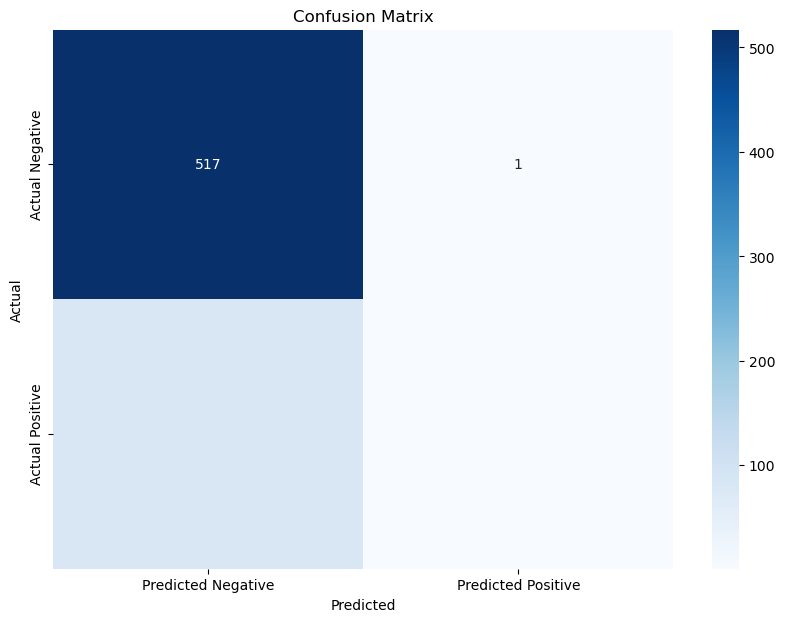

In [143]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Get the classification report
print(classification_report(y_test, y_pred))

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_test, y_pred)

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [144]:
print("Bias Mitigation Method: Reweighting")
print("")
fairness_metrics(model, X_test, df, adversarial=True)
print("")

Bias Mitigation Method: Reweighting

FAIRNESS METRICS

   pctWInvInc  pctWPubAsst  PctPopUnderPov  PctUnemployed  TotalPctDiv  \
0        0.54         0.34            0.17           0.29         0.62   
1        0.64         0.17            0.13           0.39         0.19   
2        0.40         0.13            0.10           0.22         0.40   
3        0.45         0.26            0.13           0.29         0.38   
4        1.00         0.12            0.02           0.12         0.27   

   PctFam2Par  PctKids2Par  PctYoungKids2Par  PctTeen2Par  PctIlleg  \
0        0.65         0.68              0.72         0.55      0.14   
1        0.87         0.87              0.90         0.85      0.05   
2        0.71         0.71              0.78         0.65      0.20   
3        0.73         0.77              0.80         0.77      0.11   
4        0.94         0.94              0.87         0.79      0.01   

   PctPersOwnOccup  
0             0.60  
1             0.90  
2         

/var/folders/dn/_xfnym210t70p3705v9krtf00000gn/T/ipykernel_32782/2986652886.py:90: RuntimeWarning: invalid value encountered in scalar divide
  print(f"Positive class / black communities: {tp_black/(tp_black + fp_black):.2%}")
/var/folders/dn/_xfnym210t70p3705v9krtf00000gn/T/ipykernel_32782/2986652886.py:95: RuntimeWarning: invalid value encountered in scalar divide
  positive_black = tp_black/(tp_black + fp_black)
/var/folders/dn/_xfnym210t70p3705v9krtf00000gn/T/ipykernel_32782/2986652886.py:118: RuntimeWarning: invalid value encountered in scalar divide
  print(f"Positive class / black communities: {fp_black/(tp_black + fp_black):.2%}")
/var/folders/dn/_xfnym210t70p3705v9krtf00000gn/T/ipykernel_32782/2986652886.py:123: RuntimeWarning: invalid value encountered in scalar divide
  positive_black = fp_black/(tp_black + fp_black)
/var/folders/dn/_xfnym210t70p3705v9krtf00000gn/T/ipykernel_32782/2986652886.py:148: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"Negati